In [1]:
import pandas as pd
import numpy as np


import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel, AdamW, get_linear_schedule_with_warmup
from torch.optim import AdamW
from tqdm import tqdm

import pickle
import EncoderModel as mm
import NNModel as nn2

In [2]:
df = pd.read_csv('filter_df.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65506 entries, 0 to 65505
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  65506 non-null  int64  
 1   법령명         65506 non-null  object 
 2   조문제목        65506 non-null  object 
 3   조문          65506 non-null  object 
 4   사무판단        65506 non-null  int64  
 5   사무유형(대분류)   65506 non-null  object 
 6   rule_based  65506 non-null  int64  
 7   사무예측 결과     65506 non-null  int64  
 8   사무예측 확률     65506 non-null  float64
dtypes: float64(1), int64(4), object(4)
memory usage: 4.5+ MB


In [3]:
df.shape

(65506, 9)

In [4]:
df.head(3)

,Unnamed: 0,법령명,조문제목,조문,사무판단,사무유형(대분류),rule_based,사무예측 결과,사무예측 확률
0,830918,환경영향평가법 시행규칙,규제의 재검토,② 환경부장관은 다음 각 호의 사항에 대하여 해당 호에 해당하는 날을 기준으로 2년...,0,0,1,1,0.70103
1,505105,장애인복지법 시행규칙,장애인자립생활지원센터의 운영기준,"자립생활센터는 조직 운영, 사업 수행, 재정 확보, 운용 등에 대해 객관적으로 평가...",0,0,1,1,0.58506
2,673376,국제항해선박 및 항만시설의 보안에 관한 법률 시행규칙,국제항해여객선 승객 등의 보안검색의 실시방법과 절차 등,③ 제1항의 항만시설소유자는 다음 각 호의 어느 하나에 해당하는 경우에 승선하는 자...,0,0,1,1,0.61962


In [5]:
# 사무유형 종류 불러오기
with open('subject_list.pkl', 'rb') as file:
    subject_list = pickle.load(file)

subject_list

['대도시',
 '2023 순천만국제정원박람회조직위원회',
 '5·18민주화운동 진상규명조사위원회',
 '계약담당자',
 '대검찰청',
 '대한민국법인',
 '가석방심사위원회',
 '가정보호사건조사관',
 '가정위탁지원센터',
 '가축방역기관장',
 '가축병성감정실시기관',
 '가축전염병피해보상협의회',
 '기관',
 '본부',
 '부대',
 '학교',
 '장관',
 '간사',
 '갈등관리심의위원회',
 '감독기관',
 '감독청',
 '감사',
 '감사관',
 '감사원',
 '감사위원회',
 '감사활동을 수행하는 사람',
 '감염병관리위원회',
 '감염병병원체 확인기관',
 '감정평가법인',
 '감항인증심의위원회',
 '개발센터',
 '개발원',
 '갱생보호회지소장',
 '거래소',
 '거주자',
 '건강보험공단',
 '건강보험분쟁조정위원회',
 '건강보험심사평가원',
 '건설기계사업자설립협회',
 '건설사업자',
 '건설엔지니어링사업자',
 '건설청',
 '건축위원회',
 '건축주',
 '건축허가관청',
 '검사',
 '검사공무원',
 '검사위원회',
 '검역기관',
 '검역본부',
 '검역소',
 '검정고시위원회',
 '검정기관',
 '검찰',
 '검찰관',
 '검찰단장',
 '검찰부',
 '검찰서기',
 '검찰인사위원회',
 '검찰청',
 '경계변경협의체',
 '경기도지사',
 '경상남도',
 '경영자',
 '경영책임자',
 '경쟁력위원회',
 '경제관계장관회의',
 '경제교육단체',
 '경제사회노동위원회',
 '경제자유구역위원회',
 '경제자유구역청',
 '경찰',
 '경찰공무원',
 '경찰관',
 '경찰관서',
 '경찰교육기관',
 '경찰기관',
 '경찰병원',
 '경찰서',
 '경찰청',
 '계약담당공무원',
 '계약상대방',
 '계엄사령관',
 '계정출납명령관',
 '고등검찰청',
 '고등학교',
 '고령사회위원회',
 '고용노동부',
 '고용보험위원회',
 '고용정책심의회',
 '고위공직자범죄수사처',
 '공공관리주체',
 '공공기관',
 '공공

In [6]:
# 수행주체 열 추가
df['수행주체'] = '0'

for i in tqdm(range(df.shape[0]), desc="Processing rows"):
    text = df.loc[i, '조문']
    actor = ''
    for subject in subject_list:
        if subject in text:
            actor += (' ' + subject)
    df.loc[i, '수행주체'] = actor

Processing rows: 100%|██████████████████| 65506/65506 [00:11<00:00, 5796.66it/s]


In [7]:
# 라벨 인코딩
df.loc[df['사무유형(대분류)']=='국가', '사무유형(대분류)'] = 1
df.loc[df['사무유형(대분류)']=='지방', '사무유형(대분류)'] = 2
df.loc[df['사무유형(대분류)']=='공동', '사무유형(대분류)'] = 3

df['사무유형(대분류)'] = df['사무유형(대분류)'].astype(int)

In [8]:
from sklearn.model_selection import StratifiedShuffleSplit

# StratifiedShuffleSplit을 사용하여 데이터를 분리
stratified_splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, val_index in stratified_splitter.split(df, df['사무유형(대분류)']):
    train_df = df.iloc[train_index]
    val_df = df.iloc[val_index]

In [9]:
display(train_df.head(3))
display(val_df.head(3))

,Unnamed: 0,법령명,조문제목,조문,사무판단,사무유형(대분류),rule_based,사무예측 결과,사무예측 확률,수행주체
212,810526,화학물질관리법,국가 및 지방자치단체의 책무,③ 국가는 화학물질 안전관리와 관련된 기술개발을 촉진하고 분야별 전문인력을 양성하기...,0,0,1,1,0.78197,관리 국가
61986,823563,환경보건법,환경성질환에 대한 배상책임,① 사업활동 등에서 생긴 환경유해인자로 인하여 다른 사람에게 환경성질환을 발생하게 ...,0,0,1,1,0.71983,
47371,773883,지방자치단체를 당사자로 하는 계약에 관한 법률 시행령,일괄입찰 등의 입찰 참가자격 사전심사,③ 지방자치단체의 장 또는 계약담당자는 입찰 전에 입찰에 참가하려는 자가 열람할 수...,0,0,1,1,0.78949,계약담당자 단체 하려는 자 지방자치단체


,Unnamed: 0,법령명,조문제목,조문,사무판단,사무유형(대분류),rule_based,사무예측 결과,사무예측 확률,수행주체
39545,755160,새마을금고법 시행령,분쟁조정 심의절차,① 회장은 제37조의 분쟁조정 신청서를 제출받으면 지체 없이 위원회의 회의에 부쳐야...,0,0,1,1,0.86307,위원회
13941,344345,소득세법 시행령,원천징수세액의 납부에 관한 특례,⑤기타 원천징수세액의 반기별 납부에 관하여 필요한 사항은 국세청장이 정한다. <개정...,1,1,1,1,0.63671,국세청 청장
64515,287071,자본시장과 금융투자업에 관한 법률 시행령,부수업무 등의 공고,② 금융위원회는 법 제41조제2항에 따른 제한명령이나 시정명령을 한 경우에는 그 내...,0,0,1,1,0.76118,금융위원 금융위원회 위원회


# 모델 불러오기

In [10]:
copy_df = df.copy()

copy_df['input'] = copy_df['법령명'] + '/' + copy_df['조문제목'] + '/' + copy_df['수행주체']    # 토큰화시 128차원이면 충분
copy_df

,Unnamed: 0,법령명,조문제목,조문,사무판단,사무유형(대분류),rule_based,사무예측 결과,사무예측 확률,수행주체,input
0,830918,환경영향평가법 시행규칙,규제의 재검토,② 환경부장관은 다음 각 호의 사항에 대하여 해당 호에 해당하는 날을 기준으로 2년...,0,0,1,1,0.70103,장관 환경부,환경영향평가법 시행규칙/규제의 재검토/ 장관 환경부
1,505105,장애인복지법 시행규칙,장애인자립생활지원센터의 운영기준,"자립생활센터는 조직 운영, 사업 수행, 재정 확보, 운용 등에 대해 객관적으로 평가...",0,0,1,1,0.58506,관리 센터,장애인복지법 시행규칙/장애인자립생활지원센터의 운영기준/ 관리 센터
2,673376,국제항해선박 및 항만시설의 보안에 관한 법률 시행규칙,국제항해여객선 승객 등의 보안검색의 실시방법과 절차 등,③ 제1항의 항만시설소유자는 다음 각 호의 어느 하나에 해당하는 경우에 승선하는 자...,0,0,1,1,0.61962,소유자,국제항해선박 및 항만시설의 보안에 관한 법률 시행규칙/국제항해여객선 승객 등의 보안...
3,630861,적극행정 운영규정,위원회의 구성 및 운영,"⑤ 위원회의 회의는 제4항에 따른 구성원 과반수의 출석으로 개의(開議)하고, 출석위...",0,0,1,1,0.71864,위원회,적극행정 운영규정/위원회의 구성 및 운영/ 위원회
4,16057,근로기준법,취업규칙의 작성ㆍ신고,그 밖에 해당 사업 또는 사업장의 근로자 전체에 적용될 사항,0,0,1,1,0.31071,,근로기준법/취업규칙의 작성ㆍ신고/
...,...,...,...,...,...,...,...,...,...,...,...
65501,75415,전기통신사업법,사업의 겸업,② 과학기술정보통신부장관은 기간통신사업자가 제1항에 따른 사업을 경영함으로써 전기통...,0,0,1,1,0.93022,장관 과학기술정보통신부 사업자,전기통신사업법/사업의 겸업/ 장관 과학기술정보통신부 사업자
65502,655251,남북관계 발전에 관한 법률 시행령,0,"② 기본계획 및 연도별시행계획의 변경에 관한 고시, 협조요청 및 의견통보 등에 관한...",0,0,1,1,0.65329,,남북관계 발전에 관한 법률 시행령/0/
65503,185725,지속가능 교통물류 발전법,국가 등의 책무,② 국가와 지방자치단체는 제1항에 따른 책무를 다하기 위하여 이에 따르는 예산상의 ...,0,0,1,1,0.74228,국가 단체 지방자치단체,지속가능 교통물류 발전법/국가 등의 책무/ 국가 단체 지방자치단체
65504,505164,장애인복지법 시행규칙,시설운영의 중단ㆍ재개ㆍ폐지 신고 등,장애인복지시설을 설치ㆍ운영하는 자는 법 제60조제2항에 따라 시설 운영을 일시중단또...,0,0,1,1,0.56394,구청 군수 구청장 시장 청장,장애인복지법 시행규칙/시설운영의 중단ㆍ재개ㆍ폐지 신고 등/ 구청 군수 구청장 시장 청장


In [12]:
# 모델 및 토크나이저 불러오기
model_name = 'klue/roberta-large'
tokenizer = AutoTokenizer.from_pretrained(model_name)

input_size = 128
hidden_size = 64
output_size = 4

encoder = mm.MyModel(input_size, hidden_size, output_size)
deep = nn2.MyModel(input_size, hidden_size, output_size)

In [13]:
# 데이터셋 정의
class CustomDataset(Dataset):
    def __init__(self, dataframe, tokenizer):
        self.data = dataframe
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # '조문'과 '법령명' 칼럼의 데이터를 안전하게 문자열로 변환하고 결합
        text1 = str(self.data.iloc[idx]['법령명'])
        text2 = str(self.data.iloc[idx]['조문제목'])
        text3 = str(self.data.iloc[idx]['수행주체'])
        text_data = text1 + " // " + text2 + " // " + text3
        label = torch.tensor(self.data.iloc[idx]['사무유형(대분류)'], dtype=torch.long)

        # 결합된 텍스트를 토크나이징
        tokenized_data = tokenizer([text_data], padding='max_length', max_length=128, truncation=True, return_tensors='pt')

        return {
            'input_ids': tokenized_data['input_ids'].squeeze(),
            'attention_mask': tokenized_data['attention_mask'].squeeze(),
            'labels': label
        }

In [14]:
# 각 배치의 텍스트 길이를 맞추기
def collate_fn(batch):
    input_ids = [item['input_ids'] for item in batch]
    attention_mask = [item['attention_mask'] for item in batch]
    labels = [item['labels'] for item in batch]

    # 패딩
    input_ids = torch.nn.utils.rnn.pad_sequence(input_ids, batch_first=True, padding_value=tokenizer.pad_token_id)
    attention_mask = torch.nn.utils.rnn.pad_sequence(attention_mask, batch_first=True, padding_value=0)

    return {'input_ids': input_ids, 'attention_mask': attention_mask, 'labels': torch.stack(labels)}

In [15]:
# 데이터로더 생성
batch_size = 16  # 배치크기 조절

train_dataset = CustomDataset(train_df, tokenizer)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

val_dataset = CustomDataset(val_df, tokenizer)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

In [16]:
# 손실 기록을 위한 리스트
encoder_train_losses = []
deep_train_losses = []

encoder_val_losses = []
deep_val_losses = []
num_epochs = 6
total_steps = len(train_loader) * num_epochs

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [17]:
train_df['사무유형(대분류)'].value_counts()

0    44121
1     5763
2     1442
3     1078
Name: 사무유형(대분류), dtype: int64

In [18]:
from sklearn.utils.class_weight import compute_class_weight

class_labels = [0, 1, 2, 3]  # '사무유형(대분류)' 열의 클래스 라벨
class_weights = compute_class_weight('balanced', classes=class_labels, y=train_df['사무유형(대분류)'].values)
class_weights = torch.FloatTensor(class_weights)

# 가중치 출력
print(class_weights)

tensor([ 0.2969,  2.2733,  9.0853, 12.1531])


# 인코더 학습

In [19]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

def cal_result(preds, y):
    conf_matrix = confusion_matrix(y, preds)
    print('혼동행렬')
    print(conf_matrix)
    accuracy = accuracy_score(y, preds)
    print(f'정확도: {accuracy}')
    class_report = classification_report(y, preds)
    print('Classification Report:')
    print(class_report)
    
    return conf_matrix

In [20]:
# 나머지 파라미터 정리
optimizer = AdamW(encoder.parameters(), lr=1e-5)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# 학습 루프에서 'labels'를 사용하는 부분 수정
for epoch in range(num_epochs):
    encoder.train()
    total_loss = 0.0
    for batch in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs} - Training'):
        inputs = {key: value.to(device) for key, value in batch.items() if key != 'labels'}
        labels = batch['labels'].to(device)

        # 모델에 토큰화된 입력 데이터 전달
        logits = encoder(**inputs).float()
        loss = torch.nn.functional.cross_entropy(logits, labels, weight=class_weights)
        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)
    encoder_train_losses.append(avg_train_loss)
    print(f'Epoch {epoch + 1}/{num_epochs}, Average Training Loss: {avg_train_loss}')

    encoder.eval()
    val_loss = 0.0
    y_true = []  # 실제 레이블을 저장할 리스트
    y_pred = []  # 모델의 예측 결과를 저장할 리스트
    y_probs = [] # 사무유형별 확률 저장할 리스트
    with torch.no_grad():
        for batch in tqdm(val_loader, desc=f'Epoch {epoch + 1}/{num_epochs} - Validation'):
            inputs = {key: value.to(device) for key, value in batch.items() if key != 'labels'}
            labels = batch['labels'].to(device)

            # 모델에 토큰화된 입력 데이터 전달
            outputs = encoder(**inputs).float()
            
            # 마지막 epoch에서의 확률값 저장
            if (epoch + 1) == num_epochs:
                probs = torch.nn.functional.softmax(outputs, dim=1)
                y_probs.extend(probs.cpu().numpy())
            
            _, predictions = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predictions.cpu().numpy())
            val_loss += torch.nn.functional.cross_entropy(outputs, labels, weight=class_weights)

    avg_val_loss = val_loss / len(val_loader)
    encoder_val_losses.append(avg_val_loss)
    print(f'Epoch {epoch + 1}/{num_epochs}, Validation Loss: {avg_val_loss}')

Epoch 1/6 - Training: 100%|████████████████| 3276/3276 [00:18<00:00, 179.43it/s]


Epoch 1/6, Average Training Loss: 1.3666413914007436


Epoch 1/6 - Validation: 100%|████████████████| 819/819 [00:02<00:00, 292.94it/s]


Epoch 1/6, Validation Loss: 1.3421051502227783


Epoch 2/6 - Training: 100%|████████████████| 3276/3276 [00:17<00:00, 185.37it/s]


Epoch 2/6, Average Training Loss: 1.3235662985997905


Epoch 2/6 - Validation: 100%|████████████████| 819/819 [00:02<00:00, 286.02it/s]


Epoch 2/6, Validation Loss: 1.3180311918258667


Epoch 3/6 - Training: 100%|████████████████| 3276/3276 [00:17<00:00, 184.46it/s]


Epoch 3/6, Average Training Loss: 1.3082546276087


Epoch 3/6 - Validation: 100%|████████████████| 819/819 [00:02<00:00, 287.43it/s]


Epoch 3/6, Validation Loss: 1.3076927661895752


Epoch 4/6 - Training: 100%|████████████████| 3276/3276 [00:17<00:00, 182.93it/s]


Epoch 4/6, Average Training Loss: 1.297917450977187


Epoch 4/6 - Validation: 100%|████████████████| 819/819 [00:02<00:00, 286.16it/s]


Epoch 4/6, Validation Loss: 1.3043147325515747


Epoch 5/6 - Training: 100%|████████████████| 3276/3276 [00:17<00:00, 183.53it/s]


Epoch 5/6, Average Training Loss: 1.2913949870037071


Epoch 5/6 - Validation: 100%|████████████████| 819/819 [00:02<00:00, 287.98it/s]


Epoch 5/6, Validation Loss: 1.2993133068084717


Epoch 6/6 - Training: 100%|████████████████| 3276/3276 [00:17<00:00, 182.36it/s]


Epoch 6/6, Average Training Loss: 1.2932689609472277


Epoch 6/6 - Validation: 100%|████████████████| 819/819 [00:02<00:00, 284.85it/s]

Epoch 6/6, Validation Loss: 1.2989355325698853


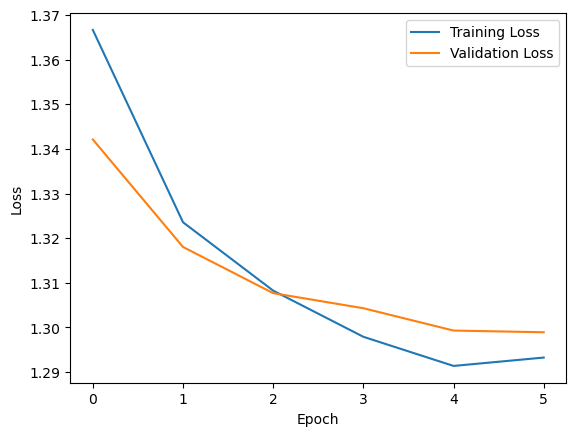

In [21]:
import matplotlib.pyplot as plt

# 손실 값 시각화
plt.plot(encoder_train_losses, label='Training Loss')
plt.plot(encoder_val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
encoder 

In [22]:
probs = pd.DataFrame(y_probs)

In [23]:
encoder_result = pd.DataFrame({
    'Label': y_true,
    'Pred': y_pred,
    '비사무 확률': round(probs[0], 5),
    '국가 확률': round(probs[1], 5),
    '지방 확률': round(probs[2], 5),
    '공동 확률': round(probs[3], 5)
})

encoder_result

,Label,Pred,비사무 확률,국가 확률,지방 확률,공동 확률
0,0,0,0.58528,0.22012,0.10110,0.09350
1,1,0,0.41062,0.34833,0.13782,0.10322
2,0,1,0.34799,0.36959,0.16767,0.11475
3,0,0,0.53338,0.25351,0.12614,0.08696
4,0,0,0.40185,0.32861,0.14689,0.12264
...,...,...,...,...,...,...
13097,1,0,0.35634,0.27615,0.16813,0.19938
13098,0,0,0.37017,0.32204,0.17019,0.13760
13099,0,0,0.47884,0.30022,0.12084,0.10010
13100,0,0,0.55462,0.20542,0.12747,0.11249


In [24]:
cal_result(encoder_result['Label'], encoder_result['Pred'])

혼동행렬
[[7938  829  182  150]
 [2291  457  104   74]
 [ 622  115   57   37]
 [ 180   40   17    9]]
정확도: 0.645779270340406
Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.87      0.79      9099
           1       0.32      0.16      0.21      2926
           2       0.16      0.07      0.10       831
           3       0.03      0.04      0.03       246

    accuracy                           0.65     13102
   macro avg       0.31      0.28      0.28     13102
weighted avg       0.58      0.65      0.60     13102



array([[7938,  829,  182,  150],
       [2291,  457,  104,   74],
       [ 622,  115,   57,   37],
       [ 180,   40,   17,    9]])

In [25]:
encoder_result

,Label,Pred,비사무 확률,국가 확률,지방 확률,공동 확률
0,0,0,0.58528,0.22012,0.10110,0.09350
1,1,0,0.41062,0.34833,0.13782,0.10322
2,0,1,0.34799,0.36959,0.16767,0.11475
3,0,0,0.53338,0.25351,0.12614,0.08696
4,0,0,0.40185,0.32861,0.14689,0.12264
...,...,...,...,...,...,...
13097,1,0,0.35634,0.27615,0.16813,0.19938
13098,0,0,0.37017,0.32204,0.17019,0.13760
13099,0,0,0.47884,0.30022,0.12084,0.10010
13100,0,0,0.55462,0.20542,0.12747,0.11249


In [28]:
encoder_result.to_csv('encoder_filter2_val_result.csv', index=False)

In [29]:
# 행별 최대값 - 두번째 최대값 차이 계싼 함수
def get_diff(df):
    df['차이'] = 0
    for i in range(len(df)):
        s_row = sorted(list(df.iloc[i, 2:6]), reverse=True)
        df.loc[i, '차이'] = s_row[0] - s_row[1]
    
    return df

# 학실 주의 구분 함수
def need_to_check_plus(threshold, df):
    df['need_to_check'] = 0
    df.loc[df['차이'] < threshold, 'need_to_check'] = 1
    return df

# 학실, 주의별 확인 함수
def check_result(result):
    jF = result.loc[(result['need_to_check']==1)&(result['Label']!=result['Pred']), :]
    jT = result.loc[(result['need_to_check']==1)&(result['Label']==result['Pred']), :]
    hF = result.loc[(result['need_to_check']==0)&(result['Label']!=result['Pred']), :]
    hT = result.loc[(result['need_to_check']==0)&(result['Label']==result['Pred']), :]
    
    print(f'주의 사무 개수: {len(jF) + len(jT)}')
    print(f'주의에서 틀린 개수: {len(jF)}')
    print(f'주의에서 맞은 개수: {len(jT)}')
    print('------------------')
    print(f'확실 사무 개수: {len(hF) + len(hT)}')
    print(f'확실에서 틀린 개수: {len(hF)}')
    print(f'확실에서 맞은 개수: {len(hT)}')
    
    h_ratio = len(hT)/(len(hF)+len(hT))
    j_ratio = len(jT)/(len(jF)+len(jT))
    
    return h_ratio, j_ratio  # 확실 사무중 맞은 것의 개수

In [30]:
result1 = get_diff(encoder_result)
thresholds = np.arange(0.1, 0.5, 0.05)

for t in thresholds:
    print(f'임계값: {t}')
    print("*************")
    ex = need_to_check_plus(t, result1)
    h_ratio, j_ratio = check_result(ex)
    print("============")
    print(f"확실 정확도: {h_ratio}")
    print(f"애매 정확도: {j_ratio}")
    print("*************")
    print()

임계값: 0.1
*************
주의 사무 개수: 5627
주의에서 틀린 개수: 3159
주의에서 맞은 개수: 2468
------------------
확실 사무 개수: 7475
확실에서 틀린 개수: 1482
확실에서 맞은 개수: 5993
확실 정확도: 0.8017391304347826
애매 정확도: 0.4385996090279012
*************

임계값: 0.15000000000000002
*************
주의 사무 개수: 7290
주의에서 틀린 개수: 3847
주의에서 맞은 개수: 3443
------------------
확실 사무 개수: 5812
확실에서 틀린 개수: 794
확실에서 맞은 개수: 5018
확실 정확도: 0.8633860977288369
애매 정확도: 0.47229080932784634
*************

임계값: 0.20000000000000004
*************
주의 사무 개수: 8524
주의에서 틀린 개수: 4196
주의에서 맞은 개수: 4328
------------------
확실 사무 개수: 4578
확실에서 틀린 개수: 445
확실에서 맞은 개수: 4133
확실 정확도: 0.9027959807776321
애매 정확도: 0.5077428437353355
*************

임계값: 0.25000000000000006
*************
주의 사무 개수: 9512
주의에서 틀린 개수: 4372
주의에서 맞은 개수: 5140
------------------
확실 사무 개수: 3590
확실에서 틀린 개수: 269
확실에서 맞은 개수: 3321
확실 정확도: 0.9250696378830083
애매 정확도: 0.5403700588730025
*************

임계값: 0.30000000000000004
*************
주의 사무 개수: 10486
주의에서 틀린 개수: 4483
주의에서 맞은 개수: 6003
------------------
확실 사무 개수: 

In [31]:
result1

,Label,Pred,비사무 확률,국가 확률,지방 확률,공동 확률,차이,need_to_check
0,0,0,0.58528,0.22012,0.10110,0.09350,0.36516,1
1,1,0,0.41062,0.34833,0.13782,0.10322,0.06229,1
2,0,1,0.34799,0.36959,0.16767,0.11475,0.02160,1
3,0,0,0.53338,0.25351,0.12614,0.08696,0.27987,1
4,0,0,0.40185,0.32861,0.14689,0.12264,0.07324,1
...,...,...,...,...,...,...,...,...
13097,1,0,0.35634,0.27615,0.16813,0.19938,0.08019,1
13098,0,0,0.37017,0.32204,0.17019,0.13760,0.04813,1
13099,0,0,0.47884,0.30022,0.12084,0.10010,0.17862,1
13100,0,0,0.55462,0.20542,0.12747,0.11249,0.34920,1


In [32]:
result1 = need_to_check_plus(0.25, result1)

In [33]:
cal_result(result1.loc[result1['need_to_check']==0, 'Label'], result1.loc[result1['need_to_check']==0,'Pred'])

혼동행렬
[[3317  191   26   25]
 [  27    4    0    0]
 [   0    0    0    0]
 [   0    0    0    0]]
정확도: 0.9250696378830083
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.93      0.96      3559
           1       0.02      0.13      0.04        31
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0

    accuracy                           0.93      3590
   macro avg       0.25      0.27      0.25      3590
weighted avg       0.98      0.93      0.95      3590



/Users/ihongju/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ihongju/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ihongju/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


array([[3317,  191,   26,   25],
       [  27,    4,    0,    0],
       [   0,    0,    0,    0],
       [   0,    0,    0,    0]])

In [34]:
cal_result(result1.loc[result1['need_to_check']==1, 'Label'], result1.loc[result1['need_to_check']==1,'Pred'])

혼동행렬
[[4621  638  156  125]
 [2264  453  104   74]
 [ 622  115   57   37]
 [ 180   40   17    9]]
정확도: 0.5403700588730025
Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.83      0.70      5540
           1       0.36      0.16      0.22      2895
           2       0.17      0.07      0.10       831
           3       0.04      0.04      0.04       246

    accuracy                           0.54      9512
   macro avg       0.29      0.27      0.26      9512
weighted avg       0.48      0.54      0.48      9512



array([[4621,  638,  156,  125],
       [2264,  453,  104,   74],
       [ 622,  115,   57,   37],
       [ 180,   40,   17,    9]])

# 2layer-NN

In [35]:
# 나머지 파라미터 정리
optimizer = AdamW(deep.parameters(), lr=1e-5)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# 학습 루프에서 'labels'를 사용하는 부분 수정
for epoch in range(num_epochs):
    deep.train()
    total_loss = 0.0
    for batch in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs} - Training'):
        inputs = {key: value.to(device) for key, value in batch.items() if key != 'labels'}
        labels = batch['labels'].to(device)

        # 모델에 토큰화된 입력 데이터 전달
        logits = deep(**inputs).float()
        loss = torch.nn.functional.cross_entropy(logits, labels, weight=class_weights)
        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)
    deep_train_losses.append(avg_train_loss)
    print(f'Epoch {epoch + 1}/{num_epochs}, Average Training Loss: {avg_train_loss}')

    deep.eval()
    val_loss = 0.0
    y_true = []  # 실제 레이블을 저장할 리스트
    y_pred = []  # 모델의 예측 결과를 저장할 리스트
    y_probs = [] # 사무유형별 확률 저장할 리스트
    with torch.no_grad():
        for batch in tqdm(val_loader, desc=f'Epoch {epoch + 1}/{num_epochs} - Validation'):
            inputs = {key: value.to(device) for key, value in batch.items() if key != 'labels'}
            labels = batch['labels'].to(device)

            # 모델에 토큰화된 입력 데이터 전달
            outputs = deep(**inputs).float()
            
            # 마지막 epoch에서의 확률값 저장
            if (epoch + 1) == num_epochs:
                probs = torch.nn.functional.softmax(outputs, dim=1)
                y_probs.extend(probs.cpu().numpy())
            
            _, predictions = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predictions.cpu().numpy())
            val_loss += torch.nn.functional.cross_entropy(outputs, labels, weight=class_weights)

    avg_val_loss = val_loss / len(val_loader)
    deep_val_losses.append(avg_val_loss)
    print(f'Epoch {epoch + 1}/{num_epochs}, Validation Loss: {avg_val_loss}')

Epoch 1/6 - Training: 100%|████████████████| 3276/3276 [00:12<00:00, 268.61it/s]


Epoch 1/6, Average Training Loss: 1.3915754032659007


Epoch 1/6 - Validation: 100%|████████████████| 819/819 [00:02<00:00, 312.64it/s]


Epoch 1/6, Validation Loss: 1.37227463722229


Epoch 2/6 - Training: 100%|████████████████| 3276/3276 [00:12<00:00, 266.08it/s]


Epoch 2/6, Average Training Loss: 1.356597277525726


Epoch 2/6 - Validation: 100%|████████████████| 819/819 [00:02<00:00, 313.75it/s]


Epoch 2/6, Validation Loss: 1.3451694250106812


Epoch 3/6 - Training: 100%|████████████████| 3276/3276 [00:12<00:00, 265.07it/s]


Epoch 3/6, Average Training Loss: 1.3402172875600857


Epoch 3/6 - Validation: 100%|████████████████| 819/819 [00:02<00:00, 317.10it/s]


Epoch 3/6, Validation Loss: 1.3402494192123413


Epoch 4/6 - Training: 100%|████████████████| 3276/3276 [00:12<00:00, 263.65it/s]


Epoch 4/6, Average Training Loss: 1.333003198234444


Epoch 4/6 - Validation: 100%|████████████████| 819/819 [00:02<00:00, 316.27it/s]


Epoch 4/6, Validation Loss: 1.327364206314087


Epoch 5/6 - Training: 100%|████████████████| 3276/3276 [00:12<00:00, 264.12it/s]


Epoch 5/6, Average Training Loss: 1.32782804744002


Epoch 5/6 - Validation: 100%|████████████████| 819/819 [00:02<00:00, 316.26it/s]


Epoch 5/6, Validation Loss: 1.3270047903060913


Epoch 6/6 - Training: 100%|████████████████| 3276/3276 [00:12<00:00, 263.71it/s]


Epoch 6/6, Average Training Loss: 1.3258587691992048


Epoch 6/6 - Validation: 100%|████████████████| 819/819 [00:02<00:00, 313.07it/s]

Epoch 6/6, Validation Loss: 1.325442910194397


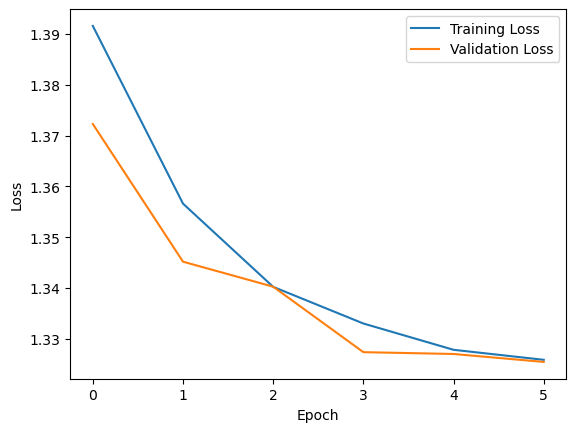

In [36]:
import matplotlib.pyplot as plt

# 손실 값 시각화
plt.plot(deep_train_losses, label='Training Loss')
plt.plot(deep_val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [37]:
probs = pd.DataFrame(y_probs)

deep_result = pd.DataFrame({
    'Label': y_true,
    'Pred': y_pred,
    '비사무 확률': round(probs[0], 5),
    '국가 확률': round(probs[1], 5),
    '지방 확률': round(probs[2], 5),
    '공동 확률': round(probs[3], 5)
})

deep_result

,Label,Pred,비사무 확률,국가 확률,지방 확률,공동 확률
0,0,0,0.50896,0.34228,0.08660,0.06215
1,1,0,0.41432,0.25397,0.16518,0.16652
2,0,0,0.30721,0.24517,0.18032,0.26730
3,0,0,0.38170,0.27025,0.24793,0.10011
4,0,0,0.35000,0.34255,0.18587,0.12158
...,...,...,...,...,...,...
13097,1,0,0.51500,0.34167,0.09674,0.04659
13098,0,1,0.38454,0.40107,0.13807,0.07632
13099,0,0,0.31728,0.31461,0.19615,0.17197
13100,0,0,0.42398,0.34294,0.13905,0.09403


In [38]:
cal_result(deep_result['Label'], deep_result['Pred'])

혼동행렬
[[7254  805  159  134]
 [2952  502  133   93]
 [ 550   88   45   27]
 [ 275   46   23   16]]
정확도: 0.5966264692413372
Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.87      0.75      8352
           1       0.35      0.14      0.20      3680
           2       0.12      0.06      0.08       710
           3       0.06      0.04      0.05       360

    accuracy                           0.60     13102
   macro avg       0.30      0.28      0.27     13102
weighted avg       0.53      0.60      0.54     13102



array([[7254,  805,  159,  134],
       [2952,  502,  133,   93],
       [ 550,   88,   45,   27],
       [ 275,   46,   23,   16]])

In [39]:
result2 = get_diff(deep_result)
thresholds = np.arange(0.1, 0.5, 0.05)

for t in thresholds:
    print(f'임계값: {t}')
    print("*************")
    ex = need_to_check_plus(t, result2)
    h_ratio, j_ratio = check_result(ex)
    print("============")
    print(f"확실 정확도: {h_ratio}")
    print(f"애매 정확도: {j_ratio}")
    print("*************")
    print()

임계값: 0.1
*************
주의 사무 개수: 7513
주의에서 틀린 개수: 3535
주의에서 맞은 개수: 3978
------------------
확실 사무 개수: 5589
확실에서 틀린 개수: 1750
확실에서 맞은 개수: 3839
확실 정확도: 0.6868849525854357
애매 정확도: 0.5294822307999467
*************

임계값: 0.15000000000000002
*************
주의 사무 개수: 9824
주의에서 틀린 개수: 4349
주의에서 맞은 개수: 5475
------------------
확실 사무 개수: 3278
확실에서 틀린 개수: 936
확실에서 맞은 개수: 2342
확실 정확도: 0.7144600366076876
애매 정확도: 0.5573086319218241
*************

임계값: 0.20000000000000004
*************
주의 사무 개수: 11271
주의에서 틀린 개수: 4766
주의에서 맞은 개수: 6505
------------------
확실 사무 개수: 1831
확실에서 틀린 개수: 519
확실에서 맞은 개수: 1312
확실 정확도: 0.7165483342435828
애매 정확도: 0.5771448851033626
*************

임계값: 0.25000000000000006
*************
주의 사무 개수: 12148
주의에서 틀린 개수: 5014
주의에서 맞은 개수: 7134
------------------
확실 사무 개수: 954
확실에서 틀린 개수: 271
확실에서 맞은 개수: 683
확실 정확도: 0.7159329140461216
애매 정확도: 0.5872571616727034
*************

임계값: 0.30000000000000004
*************
주의 사무 개수: 12631
주의에서 틀린 개수: 5155
주의에서 맞은 개수: 7476
------------------
확실 사무 개수: 4

# 두개 모델 앙상블

In [40]:
cols = ['비사무 확률', '국가 확률', '지방 확률', '공동 확률']

avg_result2 = pd.DataFrame({
    'Label':encoder_result['Label']
})

for col in cols:
    avg_result2[col] = (encoder_result[col]+deep_result[col])/2

avg_result2

,Label,비사무 확률,국가 확률,지방 확률,공동 확률
0,0,0.547120,0.281200,0.093850,0.077825
1,1,0.412470,0.301150,0.151500,0.134870
2,0,0.327600,0.307380,0.173995,0.191025
3,0,0.457540,0.261880,0.187035,0.093535
4,0,0.375925,0.335580,0.166380,0.122110
...,...,...,...,...,...
13097,1,0.435670,0.308910,0.132435,0.122985
13098,0,0.377355,0.361555,0.154130,0.106960
13099,0,0.398060,0.307415,0.158495,0.136035
13100,0,0.489300,0.274180,0.133260,0.103260


In [41]:
# 'pred' 열 추가
avg_result2['Pred'] = avg_result2[['비사무 확률', '국가 확률', '지방 확률', '공동 확률']].idxmax(axis=1)

for i in range(len(cols)):
    avg_result2.loc[avg_result2['Pred']==cols[i], 'Pred'] = i

avg_result2

,Label,비사무 확률,국가 확률,지방 확률,공동 확률,Pred
0,0,0.547120,0.281200,0.093850,0.077825,0
1,1,0.412470,0.301150,0.151500,0.134870,0
2,0,0.327600,0.307380,0.173995,0.191025,0
3,0,0.457540,0.261880,0.187035,0.093535,0
4,0,0.375925,0.335580,0.166380,0.122110,0
...,...,...,...,...,...,...
13097,1,0.435670,0.308910,0.132435,0.122985,0
13098,0,0.377355,0.361555,0.154130,0.106960,0
13099,0,0.398060,0.307415,0.158495,0.136035,0
13100,0,0.489300,0.274180,0.133260,0.103260,0


In [42]:
avg_result2['Label'] = avg_result2['Label'].astype(int)
avg_result2['Pred'] = avg_result2['Pred'].astype(int)

cal_result(avg_result2['Label'], avg_result2['Pred'])

혼동행렬
[[8055  865  179  142]
 [2393  465  122  100]
 [ 429   83   41   22]
 [ 154   28   18    6]]
정확도: 0.653869638223172
Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.87      0.79      9241
           1       0.32      0.15      0.21      3080
           2       0.11      0.07      0.09       575
           3       0.02      0.03      0.03       206

    accuracy                           0.65     13102
   macro avg       0.30      0.28      0.28     13102
weighted avg       0.60      0.65      0.61     13102



array([[8055,  865,  179,  142],
       [2393,  465,  122,  100],
       [ 429,   83,   41,   22],
       [ 154,   28,   18,    6]])

In [43]:
result3 = get_diff(avg_result2)
thresholds = np.arange(0.1, 0.55, 0.05)

for t in thresholds:
    print(f'임계값: {t}')
    print("*************")
    ex = need_to_check_plus(t, result3)
    h_ratio, j_ratio = check_result(ex)
    print("============")
    print(f"확실 정확도: {h_ratio}")
    print(f"애매 정확도: {j_ratio}")
    print("*************")
    print()

임계값: 0.1
*************
주의 사무 개수: 4788
주의에서 틀린 개수: 675
주의에서 맞은 개수: 4113
------------------
확실 사무 개수: 8314
확실에서 틀린 개수: 3860
확실에서 맞은 개수: 4454
확실 정확도: 0.5357228770748136
애매 정확도: 0.8590225563909775
*************

임계값: 0.15000000000000002
*************
주의 사무 개수: 7851
주의에서 틀린 개수: 1031
주의에서 맞은 개수: 6820
------------------
확실 사무 개수: 5251
확실에서 틀린 개수: 3504
확실에서 맞은 개수: 1747
확실 정확도: 0.33269853361264523
애매 정확도: 0.8686791491529742
*************

임계값: 0.20000000000000004
*************
주의 사무 개수: 9042
주의에서 틀린 개수: 1158
주의에서 맞은 개수: 7884
------------------
확실 사무 개수: 4060
확실에서 틀린 개수: 3377
확실에서 맞은 개수: 683
확실 정확도: 0.16822660098522169
애매 정확도: 0.8719309887193099
*************

임계값: 0.25000000000000006
*************
주의 사무 개수: 9228
주의에서 틀린 개수: 1184
주의에서 맞은 개수: 8044
------------------
확실 사무 개수: 3874
확실에서 틀린 개수: 3351
확실에서 맞은 개수: 523
확실 정확도: 0.13500258131130613
애매 정확도: 0.8716948417858691
*************

임계값: 0.30000000000000004
*************
주의 사무 개수: 9241
주의에서 틀린 개수: 1186
주의에서 맞은 개수: 8055
------------------
확실 사무 개수:

## 분포 확인

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt

result_0 = avg_result2[avg_result2['Label']==0]
result_1 = avg_result2[avg_result2['Label']==1]
result_2 = avg_result2[avg_result2['Label']==2]
result_3 = avg_result2[avg_result2['Label']==3]

Text(0, 0.5, 'Proba')

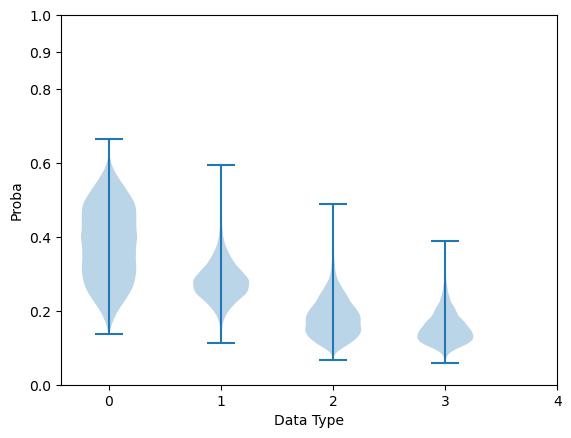

In [45]:
fig, ax = plt.subplots()
violin = ax.violinplot([result_0['비사무 확률'], result_0['국가 확률'], result_0['지방 확률'], result_0['공동 확률']], positions=[0, 1, 2, 3])
ax.set_xticks([0,1,2,3,4])
ax.set_yticks([0,0.2,0.4,0.6,0.8,0.9,1.0])
ax.set_xlabel('Data Type')
ax.set_ylabel('Proba')

Text(0, 0.5, 'Proba')

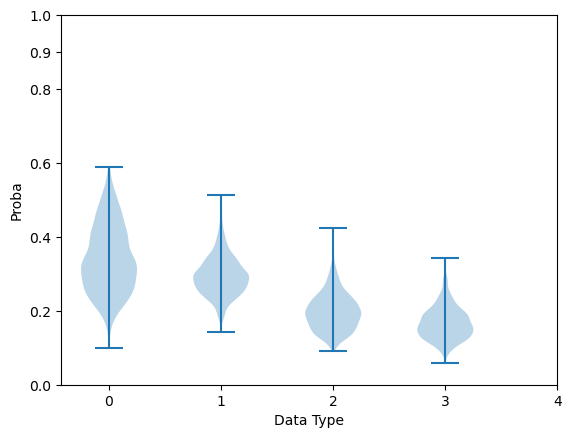

In [46]:
fig, ax = plt.subplots()
violin = ax.violinplot([result_1['비사무 확률'], result_1['국가 확률'], result_1['지방 확률'], result_1['공동 확률']], positions=[0, 1, 2, 3])
ax.set_xticks([0,1,2,3,4])
ax.set_yticks([0,0.2,0.4,0.6,0.8,0.9,1.0])
ax.set_xlabel('Data Type')
ax.set_ylabel('Proba')

Text(0, 0.5, 'Proba')

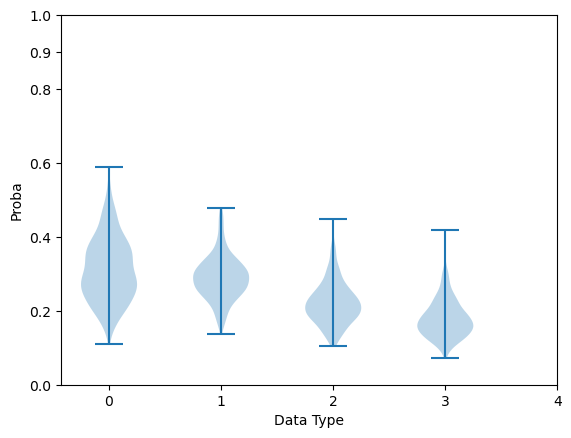

In [47]:
fig, ax = plt.subplots()
violin = ax.violinplot([result_2['비사무 확률'], result_2['국가 확률'], result_2['지방 확률'], result_2['공동 확률']], positions=[0, 1, 2, 3])
ax.set_xticks([0,1,2,3,4])
ax.set_yticks([0,0.2,0.4,0.6,0.8,0.9,1.0])
ax.set_xlabel('Data Type')
ax.set_ylabel('Proba')

Text(0, 0.5, 'Proba')

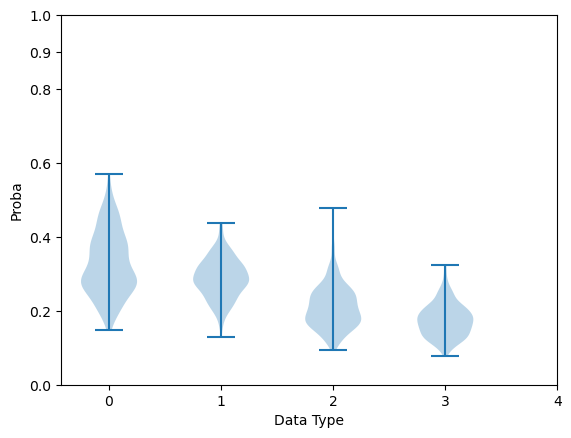

In [48]:
fig, ax = plt.subplots()
violin = ax.violinplot([result_3['비사무 확률'], result_3['국가 확률'], result_3['지방 확률'], result_3['공동 확률']], positions=[0, 1, 2, 3])
ax.set_xticks([0,1,2,3,4])
ax.set_yticks([0,0.2,0.4,0.6,0.8,0.9,1.0])
ax.set_xlabel('Data Type')
ax.set_ylabel('Proba')

# rf 모델 확인

In [ ]:
rf_result = pd.read_csv('rf_result.csv')
display(rf_result.describe())

cal_result(rf_result['사무유형(대분류)'], rf_result['y_pred'])

# 3개 모델 앙상블

In [ ]:
cols = ['비사무 확률', '국가 확률', '지방 확률', '공동 확률']

avg_result3 = pd.DataFrame({
    'Label':encoder_result['Label']
})

for col in cols:
    avg_result3[col] = (encoder_result[col]+deep_result[col]+rf_result[col])/3

avg_result3

In [ ]:
# 'pred' 열 추가
avg_result3['Pred'] = avg_result3[['비사무 확률', '국가 확률', '지방 확률', '공동 확률']].idxmax(axis=1)

for i in range(len(cols)):
    avg_result3.loc[avg_result3['Pred']==cols[i], 'Pred'] = i

avg_result3

In [ ]:
avg_result3['Label'] = avg_result3['Label'].astype(int)
avg_result3['Pred'] = avg_result3['Pred'].astype(int)

cal_result(avg_result3['Label'], avg_result3['Pred'])